In [1]:
using Revise

In [2]:
using LowRankVortex

In [3]:
using PotentialFlow

In [4]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [11]:
rmax = 3.0   # largest radial coordinate (smallest is 1)
eps = 0.00001 # small offset from the surface of the unit circle

nth = 400   # number of circumferential points
dth = 2π/nth
θ = range(0,2π,length=nth+1)
dr = dth
r = [1+eps]
while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth
end

### Create a body

In [399]:
a1 = 1.0; b1 = 1.0; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]

3-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

In [400]:
b = Bodies.ConformalBody(ccoeff,ComplexF64(0.0),0.0)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.0


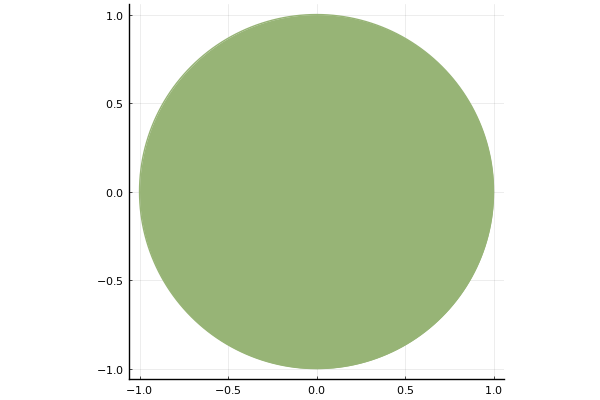

In [401]:
plot(b)

In [402]:
#vort_z = Vortex.Blob(-0.5 + 0.5im, 1.0, 0.1)
vort_z = Vortex.Blob(1.25im, 1.0, 0.1)

vort_ζ = Elements.inverse_conftransform(vort_z,b);

In [403]:
motion = RigidBodyMotion(0.0, 0.0);

In [404]:
Bodies.enforce_no_flow_through!(b, motion, vort_ζ, 0.0)

In [405]:
b.img

1-element Vector{Element}:
 Vortex.Point(0.0 + 0.8im, -1.0)

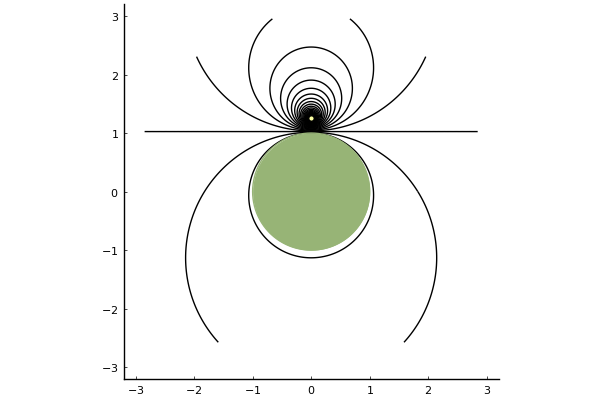

In [407]:
ps = streamlines(r,θ,(b,vort_ζ),levels=range(-0.1,0.4,length=31))
plot!(ps,(b,[vort_z]),legend=false)

### Create functions for pressure and its derivatives

In [5]:
#=
function clear_images!(b)
    b.img = Element[]
    return b
end
=#

clear_images! (generic function with 1 method)

In [6]:
#=
function _set_motion_in_quiescent(b_orig,Ũ,Ṽ,Ω)
    b = deepcopy(b_orig)
    clear_images!(b)
    motion = RigidBodyMotion((Ũ+im*Ṽ)*exp(im*b.α), Ω)
    Bodies.enforce_no_flow_through!(b, motion, () , 0.0)
    return b
end

function _set_image_for_stationary_body(b_orig,v::T,atorigin) where {T<:Element}
    b = deepcopy(b_orig)
    clear_images!(b)
    motion = RigidBodyMotion(0.0,0.0)
    sys = _preimage_system(v,atorigin)
    Bodies.enforce_no_flow_through!(b, motion, sys , 0.0)
    return b
end

_preimage_system(v,::Val{true}) = (_unit_strength_copy(v),_unit_at_origin(v)) # put an image at origin, too
_preimage_system(v,::Val{false}) = (_unit_strength_copy(v),) # for no image at origin
_unit_strength_copy(v::Vortex.Blob) = Vortex.Blob(v.z,1.0,v.δ)
_unit_strength_copy(v::Vortex.Point) = Vortex.Point(v.z,1.0)
_unit_at_origin(::Union{Vortex.Blob,Vortex.Point}) = Vortex.Point(complex(Inf),-1.0)   

"""
    Fbt1(ζ,b::ConformalBody)

Calculate the complex potential at `ζ` in the circle plane due to motion of body `b` with unit velocity
in the x̃ direction (of its own coordinate system).
"""
@inline Fbt1(ζ,b::Bodies.ConformalBody) = Elements.complexpotential(ζ,_set_motion_in_quiescent(b,1.0,0.0,0.0))

"""
    Fbt2(ζ,b::ConformalBody)

Calculate the complex potential at `ζ` in the circle plane due to motion of body `b` with unit velocity
in the ỹ direction (of its own coordinate system).
"""
@inline Fbt2(ζ,b::Bodies.ConformalBody) = Elements.complexpotential(ζ,_set_motion_in_quiescent(b,0.0,1.0,0.0))

"""
    Fbr(ζ,b::ConformalBody)

Calculate the complex potential at `ζ` in the circle plane due to motion of body `b` with unit angular velocity
about its reference point
"""
@inline Fbr(ζ,b::Bodies.ConformalBody) = Elements.complexpotential(ζ,_set_motion_in_quiescent(b,0.0,0.0,1.0))

"""
    Fv(ζ,b::ConformalBody,v::Element)

Calculate the complex potential at `ζ` in the circle plane due to a unit-strength vortex at the location of `v`,
along with its images inside the body `b`. It is presumed that the location of `v` is given in the circle plane.
"""
@inline Fv(ζ,b::Bodies.ConformalBody,v::Element) = Elements.complexpotential(ζ,(_set_image_for_stationary_body(b,v,Val(true)),_unit_strength_copy(v)))

"""
    ŵbt1(ζ,b::ConformalBody)

Calculate the complex velocity ``ŵ = û-iv̂`` at `ζ` in the circle plane due to motion of body `b` with unit velocity
in the x̃ direction (of its own coordinate system).
"""
@inline ŵbt1(ζ,b::Bodies.ConformalBody) = conj(_ŵbt1_conj(ζ,b))

"""
    ŵbt2(ζ,b::ConformalBody)

Calculate the complex velocity ``ŵ = û-iv̂`` at `ζ` in the circle plane due to motion of body `b` with unit velocity
in the x̃ direction (of its own coordinate system).
"""
@inline ŵbt2(ζ,b::Bodies.ConformalBody) = conj(_ŵbt2_conj(ζ,b))

"""
    ŵbr(ζ,b::ConformalBody)

Calculate the complex velocity in the circle plane ``ŵ = û-iv̂`` at `ζ` in the circle plane due to motion of body `b` with unit angular velocity
about its reference point.
"""
@inline ŵbr(ζ,b::Bodies.ConformalBody) = conj(_ŵbr_conj(ζ,b))

"""
    ŵv(ζ,b::ConformalBody,v::Element)

Calculate the complex velocity ``ŵ = û-iv̂`` at `ζ` in the circle plane due to a unit-strength vortex at the location of `v`,
along with its images inside the body `b`. It is presumed that the location of `v` is given in the circle plane.
"""
@inline ŵv(ζ,b::Bodies.ConformalBody,v::Element) = conj(_ŵv_conj(ζ,b,v))

@inline _ŵbt1_conj(ζ,b::Bodies.ConformalBody) = induce_velocity(ζ,_set_motion_in_quiescent(b,1.0,0.0,0.0),0.0)
@inline _ŵbt2_conj(ζ,b::Bodies.ConformalBody) = induce_velocity(ζ,_set_motion_in_quiescent(b,0.0,1.0,0.0),0.0)
@inline _ŵbr_conj(ζ,b::Bodies.ConformalBody) = induce_velocity(ζ,_set_motion_in_quiescent(b,0.0,0.0,1.0),0.0)
@inline _ŵv_conj(ζ,b::Bodies.ConformalBody,v::Element) = induce_velocity(ζ,(_set_image_for_stationary_body(b,v,Val(true)),_unit_strength_copy(v)),0.0)


"""
    wbt1(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to motion of body `b` with unit velocity
in the x̃ direction (of its own coordinate system).
"""
@inline wbt1(ζ,b::Bodies.ConformalBody) = conj(Bodies.transform_velocity(_ŵbt1_conj(ζ,b),ζ,b))

"""
    wbt2(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to motion of body `b` with unit velocity
in the ỹ direction (of its own coordinate system).
"""
@inline wbt2(ζ,b::Bodies.ConformalBody) = conj(Bodies.transform_velocity(_ŵbt2_conj(ζ,b),ζ,b))

"""
    wbr(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to motion of body `b` with unit velocity
angular velocity.
"""
@inline wbr(ζ,b::Bodies.ConformalBody) = conj(Bodies.transform_velocity(_ŵbr_conj(ζ,b),ζ,b))


"""
    winf1(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to unit velocity at infinity
in the x̃ direction (of its own coordinate system).
"""
@inline winf1(ζ,b::Bodies.ConformalBody) = 1.0 .- wbt1(ζ,b)

"""
    winf2(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to unit velocity at infinity
in the ỹ direction (of its own coordinate system).
"""
@inline winf2(ζ,b::Bodies.ConformalBody) = -im .- wbt2(ζ,b)

"""
    wrinf(ζ,b::ConformalBody)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to unit angular velocity at infinity
about the body's reference point.
"""
@inline wrinf(ζ,b::Bodies.ConformalBody) = -im*conj(b.m.(ζ)) .- wbr(ζ,b)

"""
    wv(ζ,b::ConformalBody,v::Element)

Calculate the complex velocity ``w = u-iv`` in the physical plane at 
the location mapped from `ζ` in the circle plane due to a unit-strength vortex at the location of `v`,
along with its images inside the body `b`. It is presumed that the location of `v` is given in the circle plane.
"""
@inline wv(ζ,b::Bodies.ConformalBody,v::Element) = conj(Bodies.transform_velocity(_ŵv_conj(ζ,b,v),ζ,b))
=#

wv

In [21]:
"""
    dphivdzv(ζ,b::ConformalBody,v::Element)

Calculates the derivative of the scalar potential field ``\\phi`` with respect to a change in
the body-fixed coordinates of element `v`, also accounting for the change in the image of `v`.
"""
function dphivdzv(ζ,b::Bodies.ConformalBody,v::Element)
    return conj(Bodies.transform_velocity(_dphivdzetav_conj(ζ,b,v),v.z,b))
end

function _dphivdzetav_conj(ζ,b::Bodies.ConformalBody,v::Element)
    out = induce_velocity(ζ,_unit_strength_copy(v),0.0)
    b_img = _set_image_for_stationary_body(b,v,Val(false))
    out -= conj(induce_velocity(ζ,b_img,0.0)/Elements.position(v)^2)
    return -0.5*out
end

"""
    wvv(targ::Element,src::Element,b::ConformalBody)

Calculate the complex velocity ``w = u - iv`` of the target element `targ` due to element `src` with unit strength,
also accounting for the images of `src`. If `targ` and `src` are the same element, then
it makes the Routh correction.
"""
@inline wvv(targ::Element,src::Element,b::Bodies.ConformalBody) = wv(targ.z,b,src) + 
                                                                   conj(Bodies.transform_velocity(_routh_conj(targ.z,b,Val(targ==src)),targ.z,b))

function _routh_conj(ζ,b,::Val{true})
    dz̃, ddz̃ = b.dm(ζ)
    return -conj(ddz̃/(4π*im*dz̃))
end

_routh_conj(ζ,b,::Val{false}) = complex(0.0)

function P(ζ,v::Element,b::Bodies.ConformalBody)
    return abs2.(wv(ζ,b,v)) + 4.0*real(dphivdzv(ζ,b,v)*conj(wvv(v,v,b)))
end

function Π(ζ,targ::Element,src::Element,b::Bodies.ConformalBody)
    return real(wv(ζ,b,targ).*conj(wv(ζ,b,src))) + 
           2.0*real(dphivdzv(ζ,b,targ)*conj(wvv(targ,src,b))) +
           2.0*real(dphivdzv(ζ,b,src)*conj(wvv(src,targ,b)))
end

pressure2 (generic function with 1 method)

In [8]:
a1 = 0.5; b1 = 0.1; ccoeff = ComplexF64[0.5(a1+b1),0,0.5(a1-b1)]
b = Bodies.ConformalBody(ccoeff,ComplexF64(0.0),0.0)

Body generated by: Power series map

  centroid at 0.0 + 0.0im
  angle 0.0


In [9]:
vort_z = [Vortex.Blob(0.5 + 0.2im, 1.0, 0.01), Vortex.Blob(0.2im, 1.0, 0.01)]
#vort_z = [Vortex.Blob(0.0 + 1.25im, 1.0,0.01),Vortex.Blob(0.2+1.25im, 1.0,0.01)]

vort_ζ = Elements.inverse_conftransform(vort_z,b);

In [12]:
ζg = r.*exp.(im*θ');
Zg = conftransform(ζg,b);

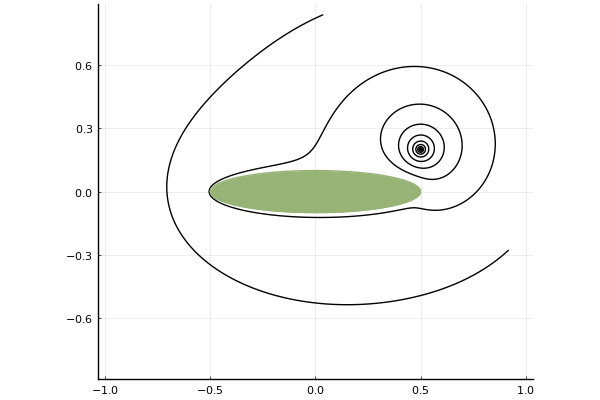

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
contour(real.(Zg),imag.(Zg),imag.(Fv(ζg,b,vort_ζ[1])),aspect_ratio=1,seriescolor = [:black, :black],colorbar=:false)
plot!(b)

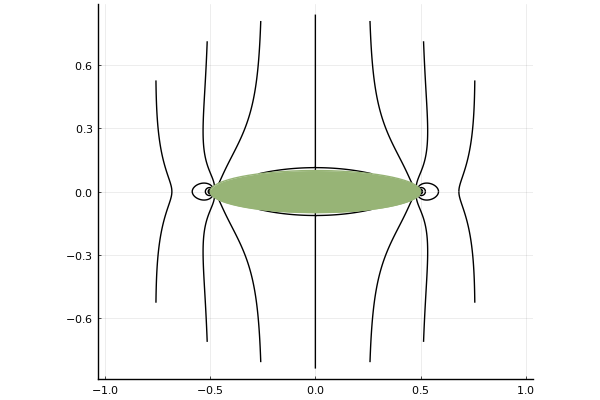

In [14]:
contour(real.(Zg),imag.(Zg),imag.(wrinf(ζg,b)),aspect_ratio=1,seriescolor = [:black, :black],colorbar=:false)
plot!(b)

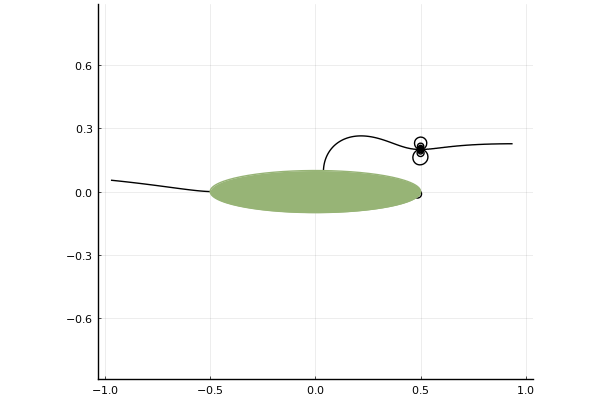

In [15]:
contour(real.(Zg),imag.(Zg),real.(wv(ζg,b,vort_ζ[1])),aspect_ratio=1,seriescolor = [:black, :black],colorbar=:false)
plot!(b)

In [39]:
function pressure2(ζ,v::Vector{T},b::Bodies.ConformalBody;kwargs...) where {T<:Element}
        out = real(zero(ζ))
        for (j,vj) in enumerate(v)
            zj,Γj  = Elements.position(vj), strength(vj)
            out -= 0.5*Γj^2*P(ζ,vj,b;kwargs...)
            for vk in v[1:j-1]
                zk,Γk  = Elements.position(vk), strength(vk)
                out -= Γj*Γk*Π(ζ,vj,vk,b;kwargs...)
            end
        end
        return out
end

pressure2 (generic function with 1 method)

In [40]:
#p = -0.5*(abs2.(wv(ζg,b,vort_ζ)) .+ 4.0*real(dphivdzv(ζg,b,vort_ζ)*conj(wvinf(vort_ζ,vort_ζ,b))));
p = pressure2(ζg,vort_ζ,b);
#p = -0.5*P(ζg,vort_ζ[1],b) + Π(ζg,vort_ζ[1],vort_ζ[2],b);

In [17]:
#p2 = LowRankVortex.pressure(Zg,[vort_z],walltype=LowRankVortex.Cylinder);
p2 = LowRankVortex.Π.(ζg,vort_ζ[1].z,vort_ζ[2].z,walltype=LowRankVortex.Cylinder);

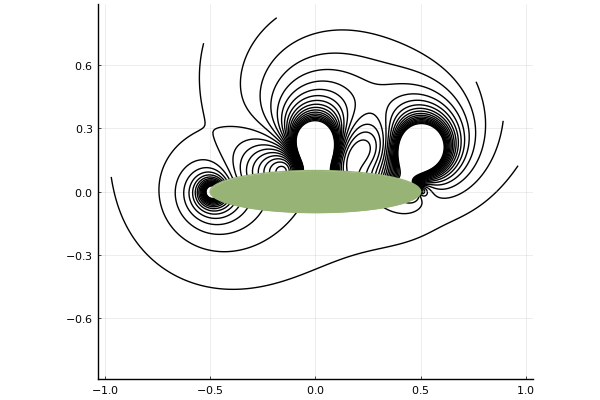

In [41]:
contour(real.(Zg),imag.(Zg),p,aspect_ratio=1,seriescolor = [:black, :black],colorbar=:false,levels=range(-1,0.5,length=31))
plot!(b)

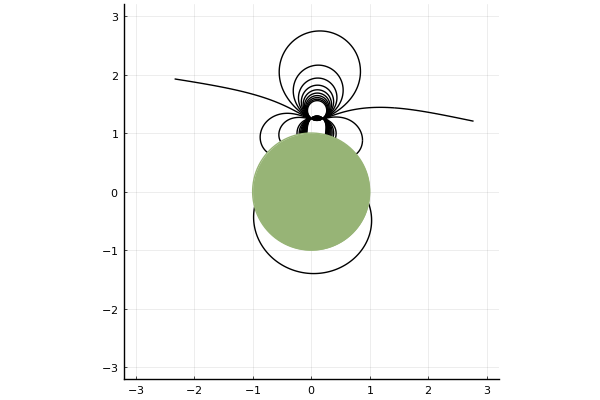

In [20]:
contour(real.(Zg),imag.(Zg),p2,aspect_ratio=1,seriescolor = [:black, :black],colorbar=:false,levels=range(-1,0.5,length=31))
plot!(b)

In [21]:
using LinearAlgebra

In [22]:
norm(p-p2)

7.914785246961426e-15